In [1]:
from pathlib import Path
from math import sqrt

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

In [2]:
def one_hot(n, i):
    q = np.zeros(n)
    q[i] = 1.0
    return q

In [3]:
train_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_train_small.csv'), delimiter=',')
test_data = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/mnist_test.csv'), delimiter=',')

In [4]:
x_train = train_data[:,1:] / 255.0
y_train = np.array([one_hot(10, int(i)) for i in train_data[:,0]])

x_test = test_data[:,1:] / 255.0
y_test = np.array([one_hot(10, int(i)) for i in test_data[:,0]])

### Define functions

In [5]:
@njit(fastmath=True)
def norm(x: np.ndarray) -> float:
    return sqrt(np.sum(np.square(x)))


@njit(fastmath=True)
def cosim(a: np.ndarray, b: np.ndarray) -> float:
    return (a @ b) / (norm(a) * norm(b))


@njit(fastmath=True)
def mcosim(m: np.ndarray, x: np.ndarray) -> float:
    y = np.zeros(m.shape[0])
    x_norm = norm(x)
    
    for i in range(m.shape[0]):
        y[i] = (m[i] @ x) / (norm(m[i]) * x_norm)
        
    return y


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)

### Define model

In [6]:
@njit(fastmath=True)
def grads_v(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray) -> tuple[np.ndarray]:
    dV = np.zeros(V.shape)

    for i in range(x_batch.shape[0]):
        x = V.T @ y_batch[i]

        dLdx = 2 * (x - x_batch[i])
        dLdV = np.outer(y_batch[i], dLdx)

        dV += dLdV

    return dV


@njit(fastmath=True)
def grads_w(x_batch: np.ndarray, y_batch: np.ndarray, V: np.ndarray, W: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    for i in range(x_batch.shape[0]):
        q = np.power(mcosim(V, x_batch[i]), 3)
        y = softmax(W @ q + b)
        dW += np.outer(y - y_batch[i], q)
        db += y - y_batch[i]

    return (dW, db)


class Perceptron:
    def __init__(self, nIn: int, nOut: int) -> None:
        self.nIn = nIn
        self.nOut = nOut

        self.V: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))

        self.W: np.ndarray = np.random.uniform(-1, 1, (nOut, nOut))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x: np.ndarray) -> np.ndarray:
        q = np.power(mcosim(self.V, x), 3)
        return softmax(self.W @ q + self.b)

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

    def train_v(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dV = grads_v(x_train[batch_idxs], y_train[batch_idxs], self.V)

                self.V -= lr * dV
    
    def train_w(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)
            n_batches = n // batch_size

            for i in range(n_batches):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dW, db = grads_w(x_train[batch_idxs], y_train[batch_idxs], self.V, self.W, self.b)

                self.W -= lr * dW
                self.b -= lr * db

### Create and train model

In [7]:
nIn = 784
nOut = 10

model = Perceptron(nIn, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(5))

untrained loss:  0.23026


In [13]:
learning_rate_1 = 1e-2
batch_size_1 = 8
max_epoch_1 = 16

model.train_v(x_train, y_train, learning_rate_1, batch_size_1, max_epoch_1)

In [9]:
learning_rate_2 = 1e-2
batch_size_2 = 8
max_epoch_2 = 8

model.train_w(x_train, y_train, learning_rate_1, batch_size_1, max_epoch_1)

In [14]:
print('trained loss: ', model.loss(x_test, y_test).round(5))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = round(n_true_pos / x_test.shape[0] * 100, 2)
print(f"test set accuracy: {accuracy}%")

trained loss:  0.05899
test set accuracy: 80.3%


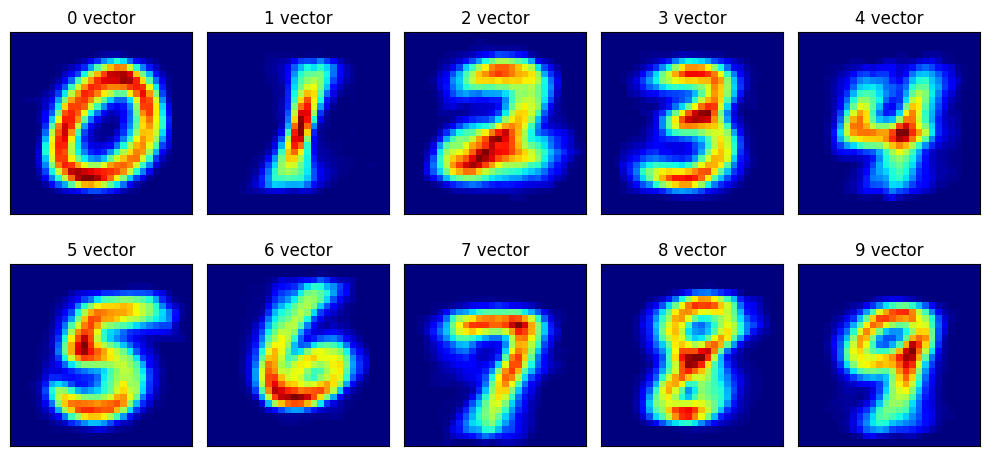

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_figwidth(10)
fig.set_figheight(5)
fig.set_dpi(100)

for i, ax in enumerate(axes.ravel()):
    img = ax.imshow(model.V[i].reshape((28, 28)), cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{i} vector')

plt.tight_layout()
plt.show()

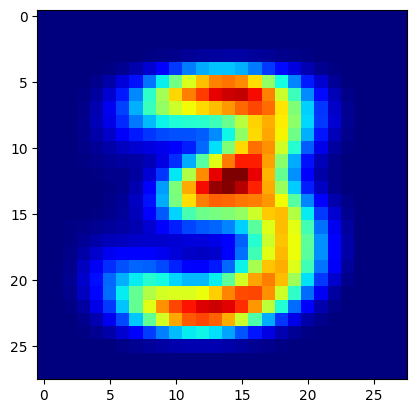

In [18]:
q = []

for i in range(len(x_train)):
    if y_train[i][3] == 1:
        q.append(x_train[i])

q = np.array(q)
avg_q = np.sum(q, axis=0)

plt.imshow(avg_q.reshape((28, 28)), cmap='jet')
plt.show()